# Выбор локации для скважины

Добывающая компания «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Для ализа возможной прибыли и рисков воспользуемся техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Согласно предоставленной документации ниже приведена расшифровка столбцов таблицы.

1. id — уникальный идентификатор скважины;
2. f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
3. product — объём запасов в скважине (тыс. баррелей).

Условия задачи:

- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

Загрузим все библиотеки, которые могут пригодиться в данном исследовании.

In [1]:
import os
import pandas as pd
import numpy as np
from numpy.random import RandomState
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from scipy import stats as st
#pd.options.mode.chained_assignment = None

In [2]:
sns.set_style('darkgrid')
sns.set(rc={"figure.figsize":(15, 5)})

Произведем выгрузку данных.


In [3]:
try:
    
    df_0 = pd.read_csv('geo_data_0.csv')
    df_1 = pd.read_csv('geo_data_1.csv')
    df_2 = pd.read_csv('geo_data_2.csv')

except:
    
    df_0 = pd.read_csv('/datasets/geo_data_0.csv')
    df_1 = pd.read_csv('/datasets/geo_data_1.csv')
    df_2 = pd.read_csv('/datasets/geo_data_2.csv')

Ознакомимся с данными. Выведем первые 5 значений для каждого датасета.

In [4]:
df_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
df_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
df_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Изучим данные.

In [7]:
df_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [8]:
df_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [9]:
df_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Следует заметить, что:
1) в столбце product отсутсвуют отрицательные значения. При этом минимальное значение равно 0, откуда можно предположить, что скважина либо пустая либо запасов в ней меньше 1 тыс. баррелей.

2) в столбцах f0-f2 имеются отрицательные значения.

Проверим наличие в датасетах пропуски.

In [10]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [11]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [12]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Пропуски в датасетах отсутсвуют. Проверим наличие явных дубликатов.

In [13]:
df_0.duplicated().sum()

0

In [14]:
df_1.duplicated().sum()

0

In [15]:
df_2.duplicated().sum()

0

Явные дубликаты отсуствуют.

## Исследовательский анализ данных

Посмотрим на доступные данные подробнее.

In [16]:
def eda(parameter_name, parameter_name_for_plots):
    #describe
    print(f'Параметр {parameter_name} в датафрейме df0:')
    display(df_0[parameter_name].describe().to_frame())
    print(f'Параметр {parameter_name} в датафрейме df1:')
    display(df_1[parameter_name].describe().to_frame())
    print(f'Параметр {parameter_name} в датафрейме df2:')
    display(df_2[parameter_name].describe().to_frame())
    
    #plots
    f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": 
                                                     (.85, .15)})
    sns.histplot(data=df_0, x=parameter_name, kde=True, ax=ax_hist)\
    .set(title=f'Гистограмма распределения признака ${parameter_name_for_plots}$, регион 0',
         ylabel='Количество записей');
    sns.boxplot(data=df_0, x=parameter_name, ax=ax_box)\
    .set(xlabel=f'Значения признака ${parameter_name_for_plots}$');
    plt.show()
    
    f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": 
                                                     (.85, .15)})
    sns.histplot(data=df_1, x=parameter_name, kde=True, ax=ax_hist)\
    .set(title=f'Гистограмма распределения признака ${parameter_name_for_plots}$, регион 1',
         ylabel='Количество записей');
    sns.boxplot(data=df_1, x=parameter_name, ax=ax_box)\
    .set(xlabel=f'Значения признака ${parameter_name_for_plots}$');
    plt.show()
    
    f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": 
                                                     (.85, .15)})
    sns.histplot(data=df_2, x=parameter_name, kde=True, ax=ax_hist)\
    .set(title=f'Гистограмма распределения признака ${parameter_name_for_plots}$, регион 2',
         ylabel='Количество записей');
    sns.boxplot(data=df_2, x=parameter_name, ax=ax_box)\
    .set(xlabel=f'Значения признака ${parameter_name_for_plots}$');
    plt.show()

Признак ***f0***


Параметр f0 в датафрейме df0:


,f0
count,100000.000000
mean,0.500419
std,0.871832
min,-1.408605
25%,-0.072580
50%,0.502360
75%,1.073581
max,2.362331


Параметр f0 в датафрейме df1:


,f0
count,100000.000000
mean,1.141296
std,8.965932
min,-31.609576
25%,-6.298551
50%,1.153055
75%,8.621015
max,29.421755


Параметр f0 в датафрейме df2:


,f0
count,100000.000000
mean,0.002023
std,1.732045
min,-8.760004
25%,-1.162288
50%,0.009424
75%,1.158535
max,7.238262


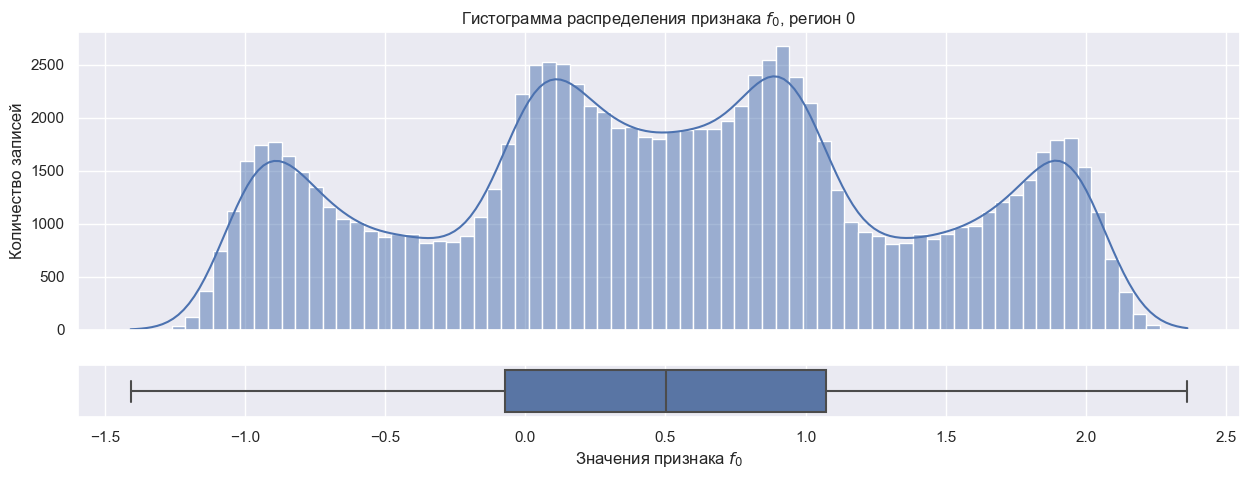

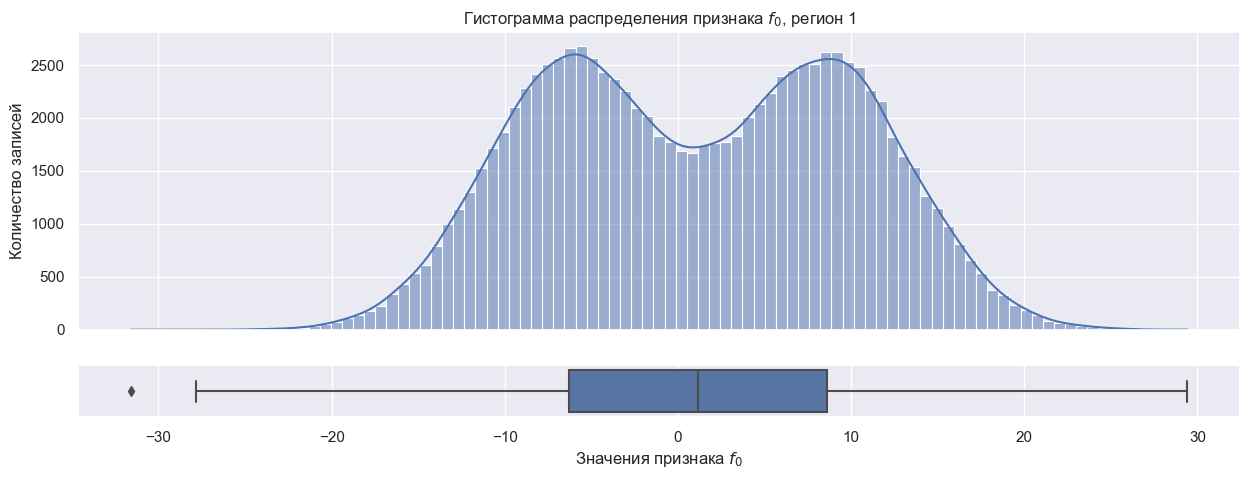

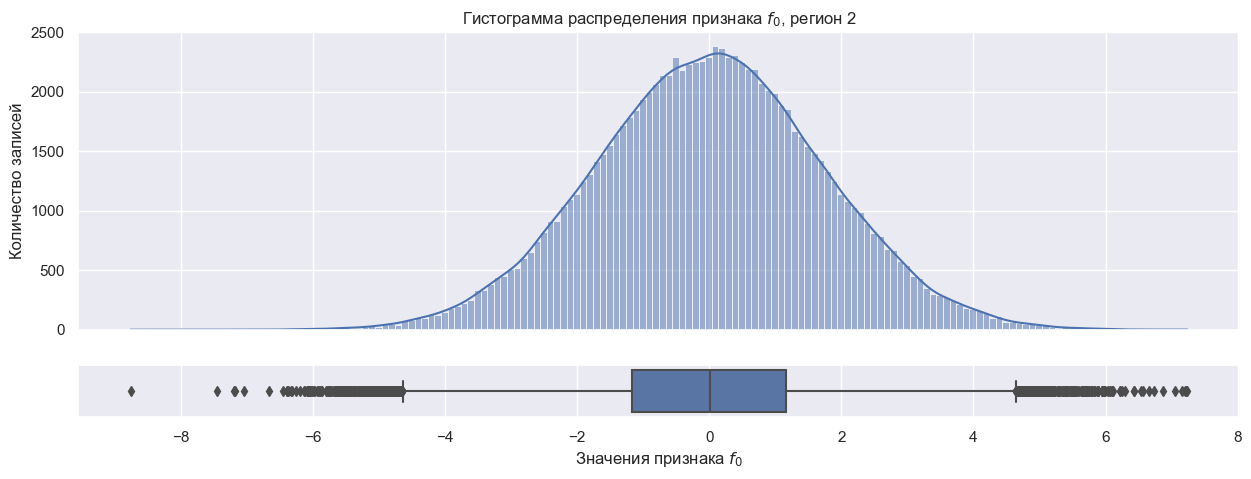

In [17]:
eda('f0', 'f_0')

Видно, что распределения признака  для различных регионов сильно отличаются. Для всех трёх регионов значения среднего или медианы близки к диапазону 0—1. Однако размах данных в регионах разный
Также различается и характер распределений. Если для региона 2 распределение похоже на нормальное, то распределение признака в первом имеет 2 выраженных пика, а распределение в нулевом регионе имеет четыре выраженных пика.

Признак ***f1***


Параметр f1 в датафрейме df0:


,f1
count,100000.000000
mean,0.250143
std,0.504433
min,-0.848218
25%,-0.200881
50%,0.250252
75%,0.700646
max,1.343769


Параметр f1 в датафрейме df1:


,f1
count,100000.000000
mean,-4.796579
std,5.119872
min,-26.358598
25%,-8.267985
50%,-4.813172
75%,-1.332816
max,18.734063


Параметр f1 в датафрейме df2:


,f1
count,100000.000000
mean,-0.002081
std,1.730417
min,-7.084020
25%,-1.174820
50%,-0.009482
75%,1.163678
max,7.844801


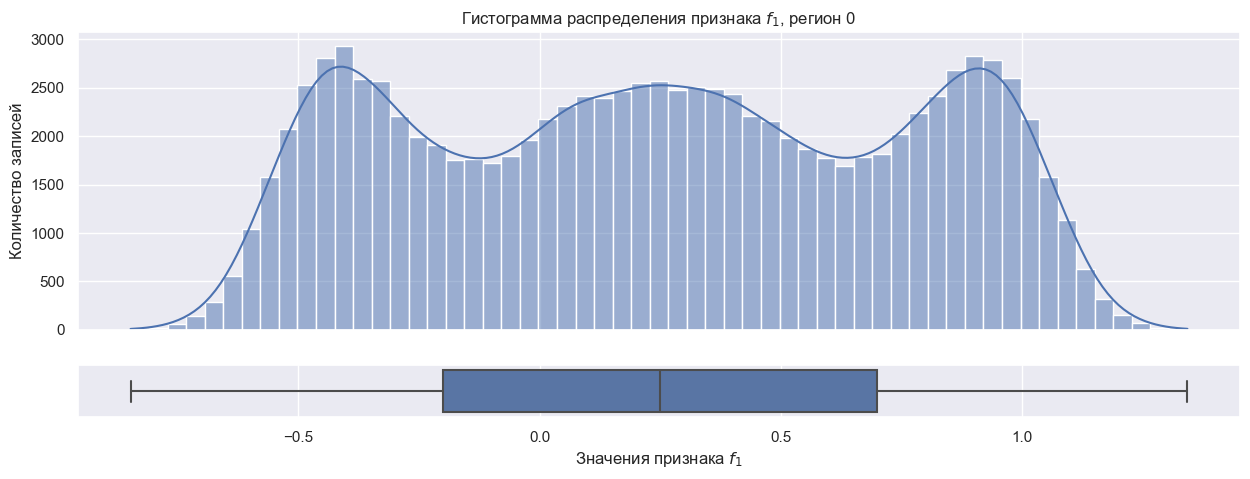

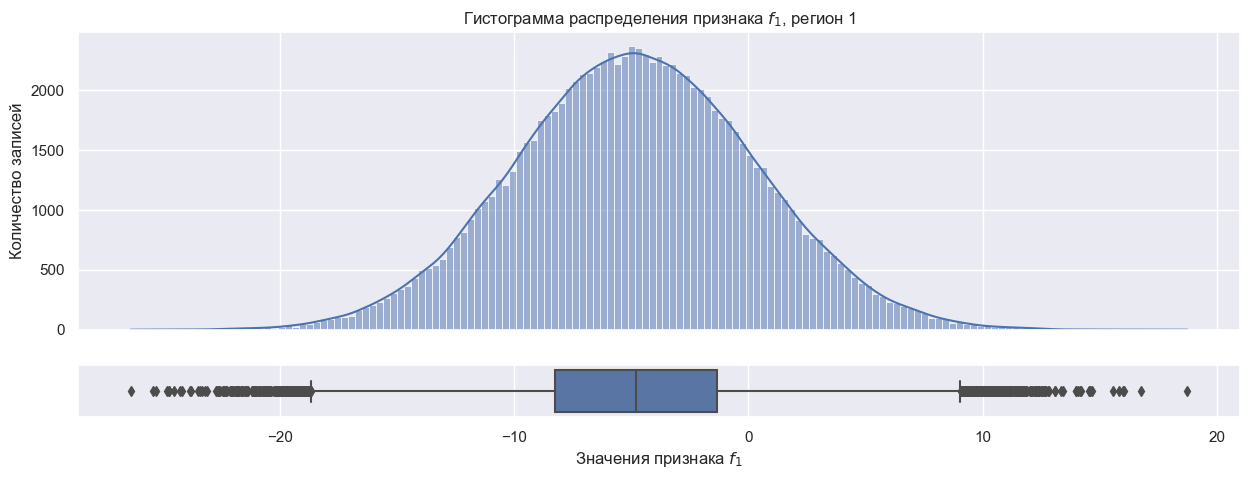

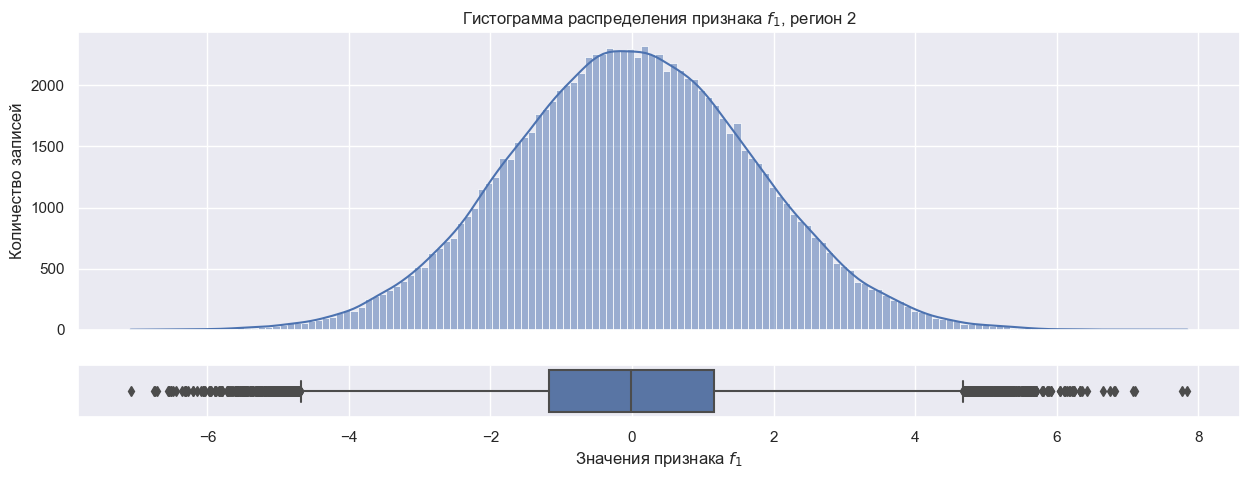

In [18]:
eda('f1', 'f_1')

Распределения признака  для различных регионов также сильно отличаются. Для регионов 0 и 2 значения среднего или медианы близки к нулю, однако для региона 1 они близки к минус пяти. Размах данных в регионах разный.

Характер распределений различается по регионам. Для регионов 1 и 2 распределение похоже на нормальное, но в распределении для региона 0 наблюдаются три выраженных пика.

eda('f2', 'f_2')

Параметр f2 в датафрейме df0:


,f2
count,100000.000000
mean,2.502647
std,3.248248
min,-12.088328
25%,0.287748
50%,2.515969
75%,4.715088
max,16.003790


Параметр f2 в датафрейме df1:


,f2
count,100000.000000
mean,2.494541
std,1.703572
min,-0.018144
25%,1.000021
50%,2.011479
75%,3.999904
max,5.019721


Параметр f2 в датафрейме df2:


,f2
count,100000.000000
mean,2.495128
std,3.473445
min,-11.970335
25%,0.130359
50%,2.484236
75%,4.858794
max,16.739402


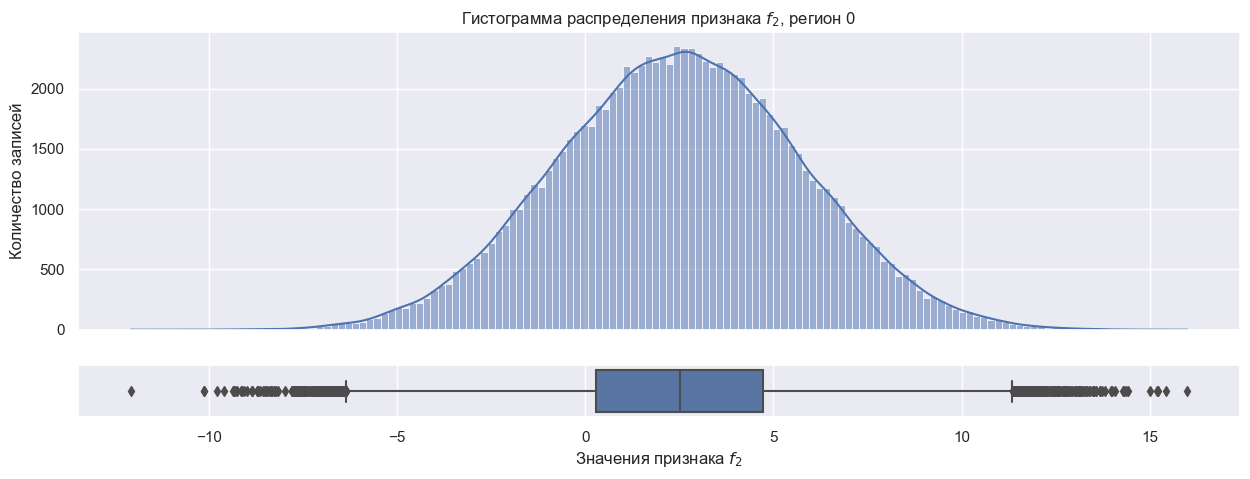

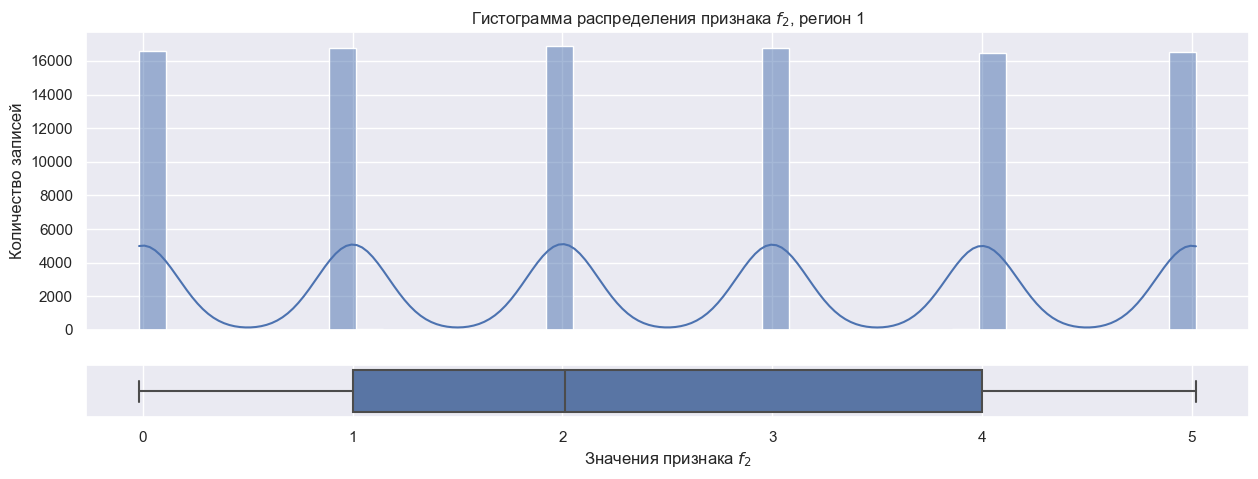

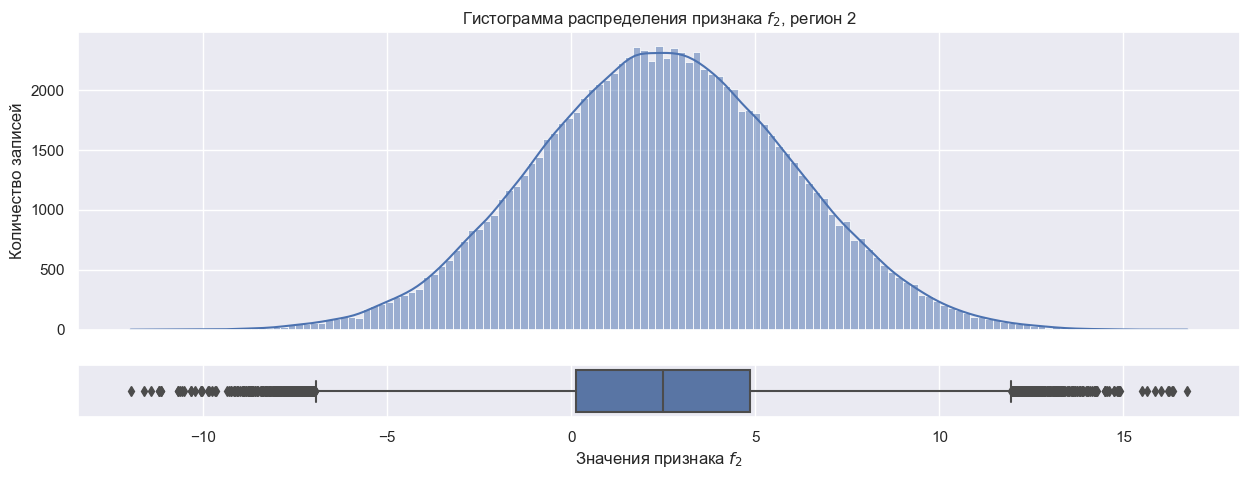

In [19]:
eda('f2', 'f_2')

Распределения признака  для регионов 0 и 2 различаются не сильно: они похожи на нормальные со средним примерно равным 2.5 и похожими стандартными отклонениями. Однако в регионе 1 характер распределения уже явно другой: данные группируются вокруг значений 0, 1 ... 5.

**Объем запасов**

Параметр product в датафрейме df0:


,product
count,100000.000000
mean,92.500000
std,44.288691
min,0.000000
25%,56.497507
50%,91.849972
75%,128.564089
max,185.364347


Параметр product в датафрейме df1:


,product
count,100000.000000
mean,68.825000
std,45.944423
min,0.000000
25%,26.953261
50%,57.085625
75%,107.813044
max,137.945408


Параметр product в датафрейме df2:


,product
count,100000.000000
mean,95.000000
std,44.749921
min,0.000000
25%,59.450441
50%,94.925613
75%,130.595027
max,190.029838


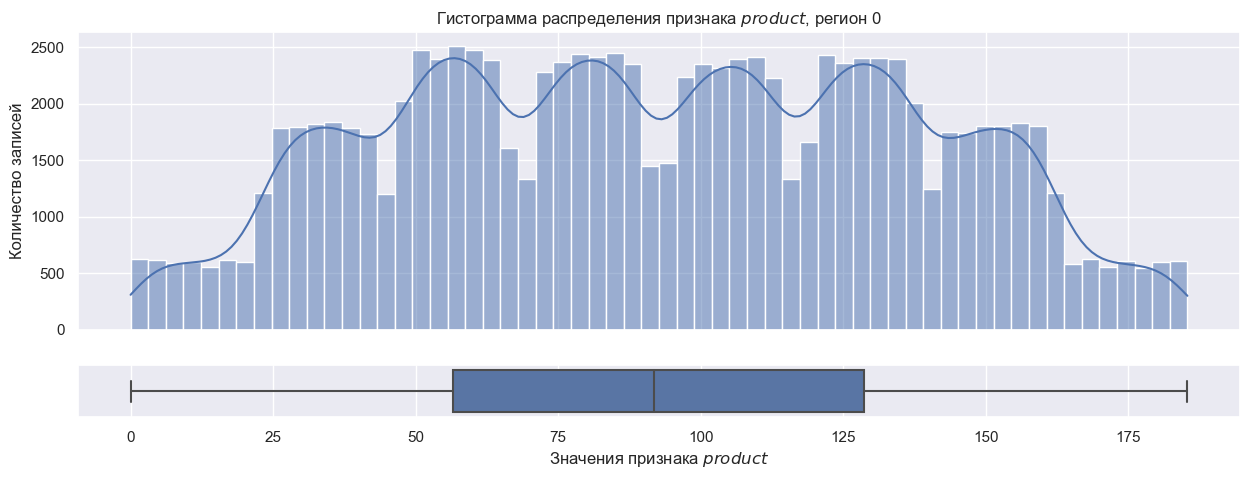

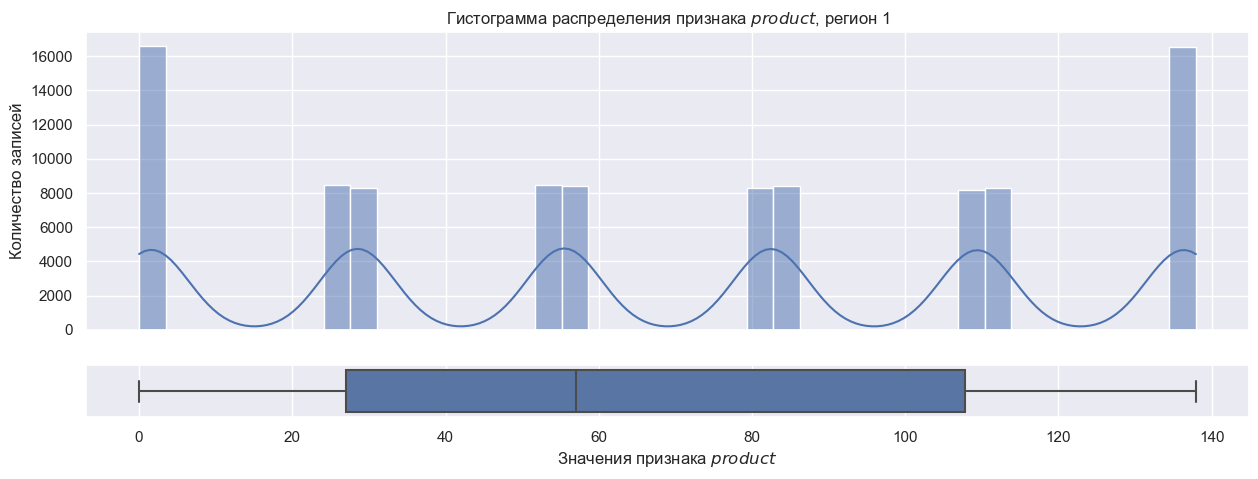

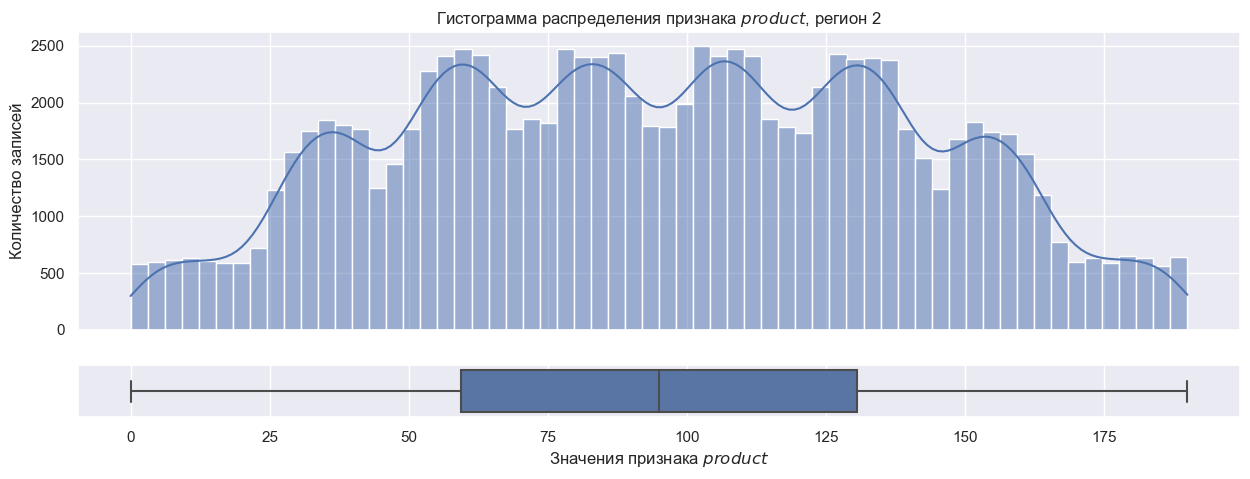

In [20]:
eda('product', 'product')

Для всех трёх регионов распределения объмов запасов отличаются от нормальных. В каждом регионе на диаграмме рассеивания можно наблюдать пики значений, в первом регионе они наиболее выражены.

Возможно подобные распределения обусловлены тем, что в регионах можно выделить характерные подрегионы, средние значения для которых и выглядят как пики на распределениях.

**Матрицы корреляций**

In [21]:
corr0 = df_0.corr()
corr1 = df_1.corr()
corr2 = df_2.corr()

/var/folders/7z/sf28v_h91tsfndytx6j96w0m0000gn/T/ipykernel_26958/4141651659.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr0 = df_0.corr()
/var/folders/7z/sf28v_h91tsfndytx6j96w0m0000gn/T/ipykernel_26958/4141651659.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr1 = df_1.corr()
/var/folders/7z/sf28v_h91tsfndytx6j96w0m0000gn/T/ipykernel_26958/4141651659.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr2 = df_2.corr()


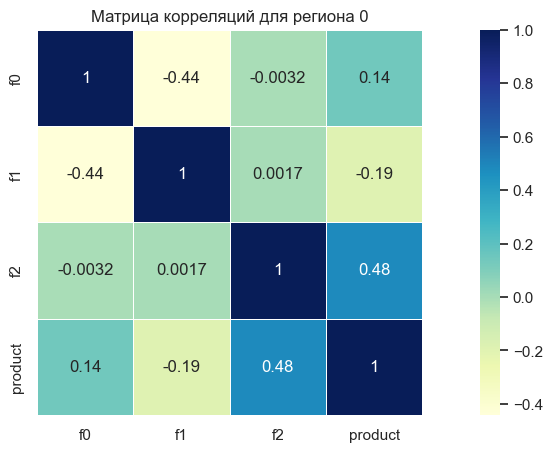

In [22]:
sns.heatmap(data=corr0, square=True, cmap="YlGnBu", linewidths=.5, annot=True)\
.set(title='Матрица корреляций для региона 0');

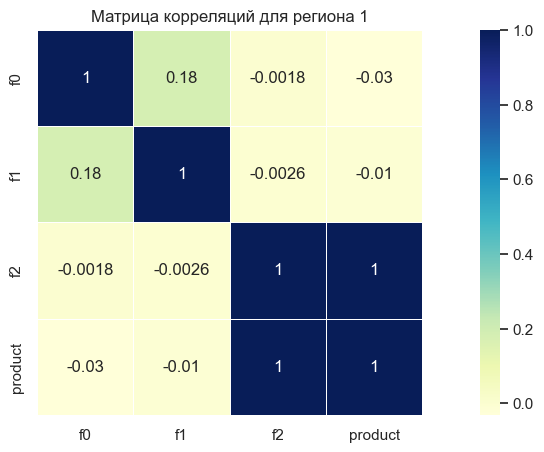

In [23]:
sns.heatmap(data=corr1, square=True, cmap="YlGnBu", linewidths=.5, annot=True)\
.set(title='Матрица корреляций для региона 1');

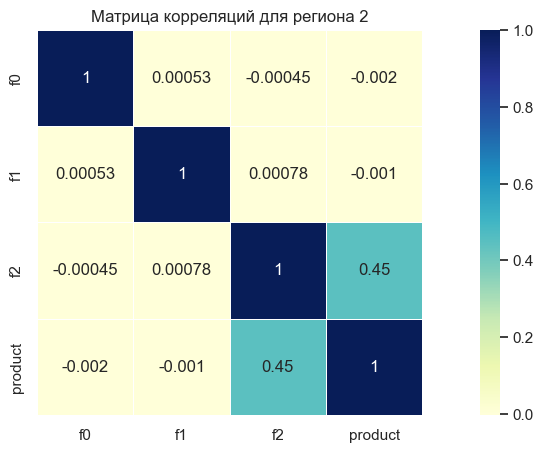

In [24]:
sns.heatmap(data=corr2, square=True, cmap="YlGnBu", linewidths=.5, annot=True)\
.set(title='Матрица корреляций для региона 2');

Для регионов 0 и 2 не наблюдается сильной корреляции между признаками. Некоторая корреляция наблюдается только между признаком  и объёмом запасов (значения коэффициента корреляции Пирсона 0,48 и 0,45).

Однако для региона 1 наблюдается очень сильная корреляция между признаком  и объёмом запасов (коэффициент корреляции Пирсона 1). Это подозрительно, возможно в данные закралась ошибка. Построим отдельно график зависимости объёмов запасов от признака  для первого региона.

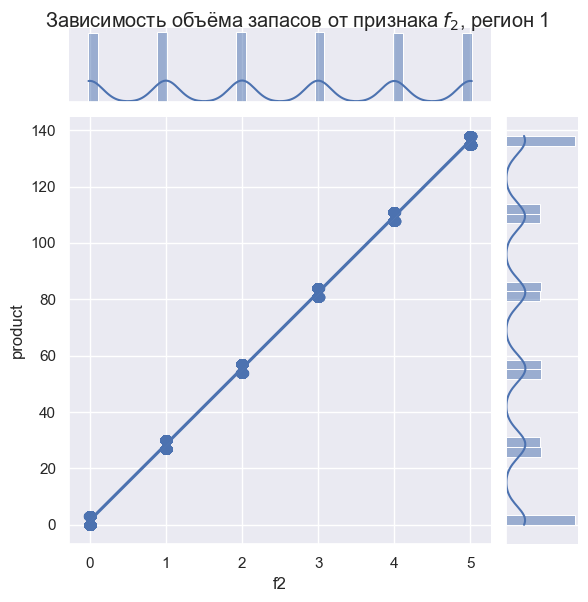

In [25]:
sns.jointplot(data=df_1, x='f2', y='product', kind='reg')
plt.suptitle('Зависимость объёма запасов от признака $f_2$, регион 1', y=1)
plt.show()

С целью дальнейших расчетов запасов нефти и расчета прибыли, для каждого датасета выделим целевой и остальные признаки, а также разделим выборки обучающие и валидационные.

In [26]:
features_df_0 = df_0.drop(['product','id'], axis = 1)
target_df_0 = df_0['product']

features_df_1 = df_1.drop(['product','id'], axis = 1)
target_df_1 = df_1['product']

features_df_2 = df_2.drop(['product','id'], axis = 1)
target_df_2 = df_2['product']

features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(features_df_0, target_df_0, 
                                                                              test_size=0.25, 
                                                                              random_state=12345)

features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_df_1, target_df_1, 
                                                                              test_size=0.25, 
                                                                              random_state=12345)

features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_df_2, target_df_2, 
                                                                              test_size=0.25, 
                                                                              random_state=12345)

## Обучение и проверка модели

Учитывая что в предоставленных данных целевой признак является количественным, то для дальнейшего проведения расчетов будем использовать линейную регрессию.

In [27]:
model_0 = LinearRegression()
model_0.fit(features_train_0 , target_train_0) 

model_1 = LinearRegression()
model_1.fit(features_train_1 , target_train_1)

model_2 = LinearRegression()
model_2.fit(features_train_2 , target_train_2)

predictions_valid_0 = model_0.predict(features_valid_0)
predictions_valid_1 = model_1.predict(features_valid_1)
predictions_valid_2 = model_2.predict(features_valid_2)

predictions_valid_0_m = pd.Series(target_valid_0.mean(), index=target_valid_0.index) #среднее значение целевого признака 
predictions_valid_1_m = pd.Series(target_valid_1.mean(), index=target_valid_1.index) #среднее значение целевого признака
predictions_valid_2_m = pd.Series(target_valid_2.mean(), index=target_valid_2.index) #среднее значение целевого признака

rmse_0 = (mean_squared_error(target_valid_0, predictions_valid_0))**0.5
rmse_1 = (mean_squared_error(target_valid_1, predictions_valid_1))**0.5
rmse_2 = (mean_squared_error(target_valid_2, predictions_valid_2))**0.5

rmse_0_m = (mean_squared_error(target_valid_0, predictions_valid_0_m))**0.5
rmse_1_m = (mean_squared_error(target_valid_1, predictions_valid_1_m))**0.5
rmse_2_m = (mean_squared_error(target_valid_2, predictions_valid_2_m))**0.5

print(f'Месторождение_0: product = {predictions_valid_0.mean()}; rmse = {rmse_0}; rmse_mean = {rmse_0_m}')
print(f'Месторождение_1: product = {predictions_valid_1.mean()}; rmse = {rmse_1}; rmse_mean = {rmse_1_m}')
print(f'Месторождение_2: product = {predictions_valid_2.mean()}; rmse = {rmse_2}; rmse_mean = {rmse_2_m}')

Месторождение_0: product = 92.59256778438035; rmse = 37.5794217150813; rmse_mean = 44.28602687855358
Месторождение_1: product = 68.72854689544602; rmse = 0.893099286775617; rmse_mean = 46.0212449226281
Месторождение_2: product = 94.96504596800489; rmse = 40.02970873393434; rmse_mean = 44.902084376898294


**Вывод**
1. Средний запас предсказанного сырья у месторождений №0 и №2.
2. Самый низкий средний запас у месторождения №1, при этом самое низкое значение rsme для предсказанной модели. Отсюда на данном этапе можно предположить, что данное месторождение может оказаться менее рискованным для вложений.

## Подготовка к расчёту прибыли

Согласно условиям задачи известно, что:

- Бюджет на разработку  — 10 млрд рублей.
-  Доход с каждой единицы продукта составляет 450 тыс. за в тысячу баррелей.

Введем данные постоянные и расчитаем минимальное среднее количество продукта, в месторождении региона, достаточного для разработки.


In [28]:
BUDGET = 10000 # бюджет в млн рублей
POINT_PER_BUDGET = 200 # количество разрабатываемых точек
PRODUKT_PRICE = 0.45 # доходность одной единицы барреля в млн рублей

budget_per_point = BUDGET/POINT_PER_BUDGET # бюджет для разработки одной скважины
product_value_point = budget_per_point/PRODUKT_PRICE # необходимый объем скважины, достаточный для разработки

print(f'Бюджет для разработки одной скважины: {budget_per_point} млн. руб')
print(f'Необходимый объем скважины, достаточный для разработки: {product_value_point:0.3f} тыс. барелей')

Бюджет для разработки одной скважины: 50.0 млн. руб
Необходимый объем скважины, достаточный для разработки: 111.111 тыс. барелей


**Вывод**

По результатам расчетов видно, что на разработку 1-й скважины требуется 50 млн. руб.

Необходимый объем запасов нефти в зоне одной скважины должем быть порядка 111 тыс. барелей.
Следует отметить, что необходимый объем значительно выше, чем предскажанные значения по модели.

Учитывая что теория с практикой может сильно отличаться, наиболее подходящее месторожденеие будем выбирать далее с оценкой рисков.

На данном этапе подготовим функцию расчета прибыли при разработке скважин.

In [29]:
target_valid_0 = target_valid_0.reset_index(drop=True)
target_valid_1 = target_valid_1.reset_index(drop=True)
target_valid_2 = target_valid_2.reset_index(drop=True)

predictions_valid_0 = pd.Series(predictions_valid_0).reset_index(drop=True)
predictions_valid_1 = pd.Series(predictions_valid_1).reset_index(drop=True)
predictions_valid_2 = pd.Series(predictions_valid_2).reset_index(drop=True)

def profit(target, predictions, count):
    #target = target.reset_index(drop=True)
    #predictions = pd.Series(predictions).reset_index(drop=True)
    #pred_series = pd.Series(data = predictions, index = target.index)
    probs_sorted = predictions.sort_values(ascending=False)
    #probs_sorted = predictions.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return (0.45 * selected.sum()) - BUDGET

## Расчёт прибыли и рисков 

На данном этапе расчитаем прибыли по скважинам


In [30]:
df_0_profit = profit(target_valid_0, predictions_valid_0, 200)
df_0_profit

3320.8260431398503

In [31]:
df_1_profit = profit(target_valid_1, predictions_valid_1, 200)
df_1_profit

2415.086696681512

In [32]:
df_2_profit = profit(target_valid_2, predictions_valid_2, 200)
df_2_profit

2710.3499635998323

Наилучшие результаты по прибыли показывают месторождения №0 (13 310 826.04 млн. руб.) и №2 (12 700 349.96 млн. руб.)

Для оценки рисков и прибыли по каждому региону, применим технику bootstrap.

In [33]:
state = np.random.RandomState(12345)


values_0 = []
values_1 = []
values_2 = []
for i in range(1000):
    target_subsample_0 = target_valid_0.sample(n=500, replace=True, random_state=state)
    probs_subsample_0 = pd.Series(predictions_valid_0[target_subsample_0.index])
    values_0.append(profit(target_subsample_0, 
                          probs_subsample_0,
                          200))    
    
for i in range(1000):
    target_subsample_1 = target_valid_1.sample(n=500, replace=True, random_state=state)
    probs_subsample_1 = pd.Series(predictions_valid_1[target_subsample_1.index])
    values_1.append(profit(target_subsample_1, 
                          probs_subsample_1,
                          200))
    
for i in range(1000):
    target_subsample_2 = target_valid_2.sample(n=500, replace=True, random_state=state)
    probs_subsample_2 = pd.Series(predictions_valid_2[target_subsample_2.index])
    values_2.append(profit(target_subsample_2, 
                          probs_subsample_2,
                          200))        
    
values_0 = pd.Series(values_0)
lower_0 = values_0.quantile(0.025)
upper_0 = values_0.quantile(0.975)
mean_0 = values_0.mean()
#confidence_interval_0 = st.t.interval(0.95, len(values_0)-1, loc = values_0.mean(), scale =values_0.sem())
sum_0 = values_0.sum()

values_1 = pd.Series(values_1)
lower_1 = values_1.quantile(0.025)
upper_1 = values_1.quantile(0.975)
mean_1 = values_1.mean()
#confidence_interval_1 = st.t.interval(0.95, len(values_1)-1, loc = values_1.mean(), scale =values_1.sem())
sum_1 = values_1.sum()

values_2 = pd.Series(values_2)
lower_2 = values_2.quantile(0.025)
upper_2 = values_2.quantile(0.975)
mean_2 = values_2.mean()
#confidence_interval_2 = st.t.interval(0.95, len(values_2)-1, loc = values_2.mean(), scale =values_2.sem())
sum_2 = values_2.sum()

def calc_risk(values_): #добавил функцию для расчета рисков. Считаем значения прибыли, которые меньше 0. Их количество делим на общее количество
    loss_point = 0
    for i in range(len(values_)):
        if values_[i] < 0:
            loss_point += 1
    risk = loss_point/len(values_)
    return risk


print("Средняя прибыль, месторождение №0:", mean_0)
print("Доверительный интервал(месторождение №0):", lower_0, '-',upper_0)
print("Риск убытков, (месторождение №0):", calc_risk(values_0))
print("Суммарная прибыль:", sum_0)
print()
print("Средняя прибыль, месторождение №1:", mean_1)
print("Доверительный интервал(месторождение №1):", lower_1, '-',upper_1)
print("Риск убытков, (месторождение №1):", calc_risk(values_1))
print("Суммарная прибыль:", sum_1)
print()
print("Средняя выручка, месторождение №2:", mean_2)
print("Доверительный интервал(месторождение №2):", lower_2, '-',upper_2)
print("Риск убытков (месторождение №2):", calc_risk(values_2))
print("Суммарная прибыль:", sum_2)


Средняя прибыль, месторождение №0: 425.9385269105927
Доверительный интервал(месторождение №0): -102.09009483793592 - 947.976353358369
Риск убытков, (месторождение №0): 0.06
Суммарная прибыль: 425938.5269105927

Средняя прибыль, месторождение №1: 518.2594936973252
Доверительный интервал(месторождение №1): 128.12323143308453 - 953.6129820669079
Риск убытков, (месторождение №1): 0.003
Суммарная прибыль: 518259.49369732523

Средняя выручка, месторождение №2: 420.19400534405037
Доверительный интервал(месторождение №2): -115.85260916001138 - 989.6299398445756
Риск убытков (месторождение №2): 0.062
Суммарная прибыль: 420194.00534405035


## Общий вывод

Наилучшим месторождением для инвестирования в разработку будет №2, так как:

1) У нее самая высокая средняя прибыль: 518 млн. руб.

2) У нее самая высокая суммарная прибыль: 518 259 млн. руб.

3) Отсуствие в доверительном интервале убытков (отрицательной прибыли)

4) Самый низкий риск убытков: 0,3%.